# Extended Game of Life
Invented by [Conway](https://en.wikipedia.org/wiki/John_Horton_Conway) in 1970, the [game of life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) is a quite fascinating application of [cellular automata](https://en.wikipedia.org/wiki/Cellular_automaton) with deep implications in computer science and mathematics. Let's just see here how to make a pretty flexible multi-valued and multi-dimensional implementation of them leveraging [numpy](https://numpy.org/).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import imageio
from IPython.display import display, Image

cmap = colors.ListedColormap(['blue', 'white', 'red'])
N = 15

We begin with defining a `NxN` grid with random integer values in (0, 1, 2) on its squares:

In [2]:
arr = np.random.randint(3, size=N * N, dtype=np.int8).reshape(N, N)

Then for each value we define:
1. the surrounding for cells in the gris having this value
2. the rules to apply for these cells

for the cells having value 0, the surrounding is `[(1, 0), (-1, 0), (0, 1), (0, -1)]`. It means for each of those cells, at position say `p`, we will sum the values of the cells located at `p + (1, 0)`, `p + (-1, 0)`, `p + (0, 1)` and `p + (0, -1)`. If the a surrounding cell lands over the edge, it continues on the other side.

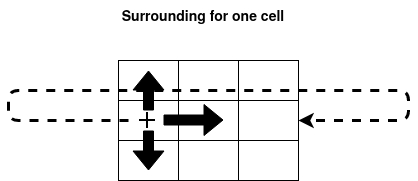

In [3]:
with open('surrounding.png', 'rb') as f:
    display(Image(data=f.read(), format='png'))

The *transitions* correspond to the mapping of this sum to (0, 1, 2). For example, `transitions_0 = [((0, 1), 1), ((2, 3), 1), ((4, np.inf), 0)]` means that if $0 <= sum <= 1$ then the concerned cell will turn to value $1$, if $2 <= sum <= 3$ then the concerned cell will turn to value $1$ also, if $sum >= 4$ it will turn to $0$.

In [4]:
# Tuple ind surroundings must have at most as many elements as dimensions in `arr`
surrounding_0 = [(1, 0), (-1, 0), (0, 1), (0, -1)]
surrounding_1 = [(1, 1), (-1, -1), (-1, 1), (1, -1)]
surrounding_2 = [(1, 1), (-1, -1), (-1, 1), (1, -1)]

transitions_0 = [((0, 1), 1), ((2, 3), 1), ((4, np.inf), 0)]
transitions_1 = [((0, 2), 0), ((3, 3), 1), ((4, np.inf), 1)]
transitions_2 = [((0, 2), 2), ((3, 4), 1), ((4, np.inf), 0)]

rules = {
    0: (surrounding_0, transitions_0), 
    1: (surrounding_1, transitions_1),
    2: (surrounding_2, transitions_2)
}

Now we define a few functions to compute each step of the evolution of the grid:

In [5]:
def get_values(arr, surrounding):
    """ Compute and returns an array `value` corresponding to the sum of 
    the values in the `surrounding` of each cell in `arr` """
    values = np.zeros(shape=arr.shape)
    for cell in surrounding:
        intermediary = arr.copy()
        for i in range(len(cell)):
            intermediary = np.roll(intermediary, cell[i], axis=i)
        values = np.add(values, intermediary).astype(np.int8)
    return values


def get_result(values, transitions, mask):
    """ Computes an array `value` corresponding to the 
    `transitions` applied to the cells in the `mask` """
    for (inf, sup), rvalue in transitions:
        mask_rule = (values >= inf) & (values <= sup) & mask
        np.putmask(values, mask_rule, rvalue)
    return values


def forward(arr, rules):
    """ Compute the next step by applying successively the sum for each step correponding its 
    surrounding and then the transitions. The surroundings and the transitions are defined 
    for each possible cell value in `rules` """
    for value, (surrounding, transitions) in rules.items():
        mask = (arr == value)
        values = get_values(arr, surrounding)
        arr = get_result(values, transitions, mask)
        np.putmask(arr, mask, values)
    return arr

We can visualize the result of one step forward for `arr`:

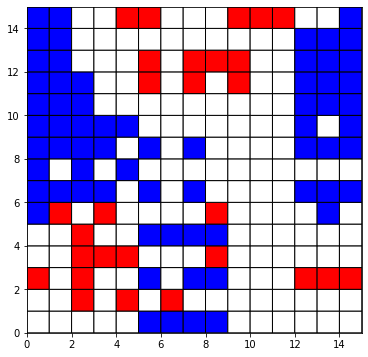

In [6]:
arr = forward(arr, rules)

plt.figure(figsize=(6,6))
plt.pcolor(arr[::-1], cmap=cmap ,edgecolors='k', linewidths=1)
plt.show()

We can also genrate and save a gif reprensenting the evolution of the grid `arr` over many steps:

In [7]:
n_steps = 30
path = './gol.gif'
fps = 5


def generate_gif(n_steps, arr, rules, path, cmap, figsize=(6, 6), fps=5):
    """
    Generate and save a gif to `path` corresponding to `n_steps`successive 
    steps of evolution of `arr` according to `rules`
    :param n_step: int, number of steps to make the grid `arr` evolve
    :param arr: numpy array of the initial grid
    :param rules: dic,  value => (surrounding, transitions)
    :param path: path where to save the resulting gif
    :param cmap: matplotlib cmap object. Must contains as many colors as possible values in `arr`
    :param figsize: size of each figure in the gif
    :param fps: frames per second for the resulting gif
    """
    images = []
    for i in range(n_steps):
        if i > 0:
            arr = forward(arr, rules)

        fig, ax = plt.subplots(figsize=(6, 6))
        ax.pcolor(arr[::-1], cmap=cmap ,edgecolors='k', linewidths=1)
        ax.set_xticks([])
        ax.set_yticks([])
        # Used to return the plot as an image rray
        fig.canvas.draw() # draw the canvas, cache the renderer
        plt.close(fig)  # Prevent each individual image for the gif to be displayed here
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)
    imageio.mimsave(path, images, fps=fps)
    print(f'INFO: gif saved to {path}')


generate_gif(n_steps, arr, rules, path, cmap, figsize=(6, 6), fps=5)

INFO: gif saved to ./gol.gif


and display it:

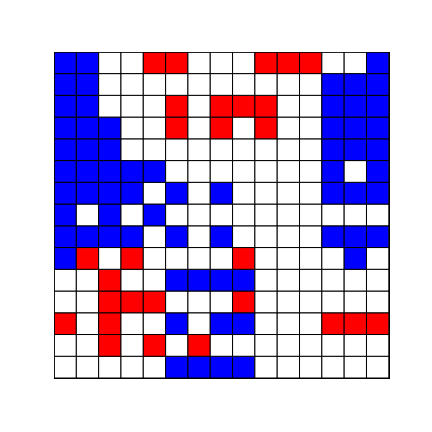

In [8]:
with open(path, 'rb') as f:
    display(Image(data=f.read(), format='png'))

## Multi-dimensional and multi-valued
Nothing prevents us to define the a game of life for say a 4-dimensional hypercube of dimension 15x20x30x10 with 5 possible values:

In [9]:
cmap = colors.ListedColormap(['blue', 'white', 'red', 'green', 'yellow', 'black'])
K, N, M, P = 15, 20, 30, 10


surrounding_0 = [(1, 0, 2, 1), (-1, 0, 1, 3), (0, 1, 0, 3), (0, -1, 3, 1)]
surrounding_1 = [(1, 1, -2, 1), (-1, -1, 1, 1), (-1, 1, 1, 0), (1, 3, -1, 4)]
surrounding_2 = [(1, 1, 2, 2), (-1, -1, -1, 1), (-1, 1, -1, 1), (1, -1, 1, 1)]
surrounding_3 = [(1, 0, 0, 1), (-1, 0, 1, 0), (0, 1, 1, 0), (0, -1, 1, -1)]
surrounding_4 = [(1, 1, 2, 1), (-1, -1, 1, 2), (-1, 1, 1, 1), (1, 1, 2, -1)]
surrounding_5 = [(2, 1, 1, 0), (-1, 2, -1, 1), (-1, 1, 1, -1), (1, 1, -1, -1)]

transitions_0 = [((0, 1), 1), ((2, 3), 1), ((4, 6), 3), ((7, 9), 4), ((10, np.inf), 0)]
transitions_1 = [((0, 2), 0), ((3, 3), 1), ((4, 10), 2), ((11, np.inf), 1)]
transitions_2 = [((0, 2), 2), ((3, 4), 1), ((5, 6), 3), ((7, 7), 1), ((8, 8), 4), ((9, np.inf), 5)]
transitions_3 = [((0, 1), 1), ((2, 3), 1), ((3, 6), 4), ((7, 9), 5), ((10, np.inf), 4)]
transitions_4 = [((0, 2), 0), ((3, 3), 1), ((4, 6), 4), ((7, np.inf), 5)]
transitions_5 = [((0, 2), 2), ((3, 4), 1), ((5, 6), 2), ((7, 7), 5), ((8, np.inf), 2)]

rules = {
    0: (surrounding_0, transitions_0), 
    1: (surrounding_1, transitions_1),
    2: (surrounding_2, transitions_2),
    3: (surrounding_3, transitions_3), 
    4: (surrounding_4, transitions_4),
    5: (surrounding_5, transitions_5)
}

arr = np.random.randint(6, size=K * N * M * P, dtype=np.int8).reshape(K, N, M, P)

We can reprensent only a 2-dimensional slice of `arr`, so let's drow for example the slice correponding the the position 3 in the second dimension and position 4 in the fourth dimension:

INFO: gif saved to ./gol_multi.gif


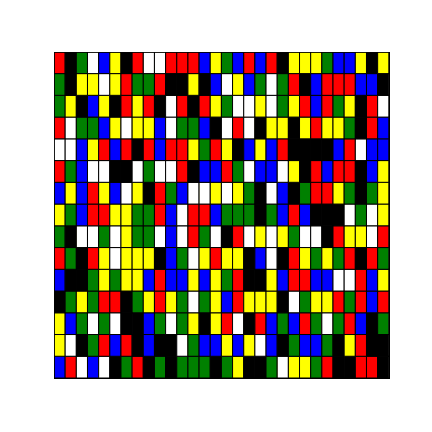

In [10]:
def generate_gif_slice(n_steps, arr, rules, path, cmap, figsize=(6, 6), fps=5):
    """
    Generate and save a gif to `path` corresponding to `n_steps`successive 
    steps of evolution of `arr` according to `rules`
    :param n_step: int, number of steps to make the grid `arr` evolve
    :param arr: numpy array of the initial grid
    :param rules: dic,  value => (surrounding, transitions)
    :param path: path where to save the resulting gif
    :param cmap: matplotlib cmap object. Must contains as many colors as possible values in `arr`
    :param figsize: size of each figure in the gif
    :param fps: frames per second for the resulting gif
    """
    images = []
    for i in range(n_steps):
        if i > 0:
            arr = forward(arr, rules)

        fig, ax = plt.subplots(figsize=(6, 6))
        arr_plotted = np.squeeze(arr[:,3,:,4])  # slice hard-encoded here, bit sub-optimal
        ax.pcolor(arr_plotted[::-1], cmap=cmap ,edgecolors='k', linewidths=1)
        ax.set_xticks([])
        ax.set_yticks([])
        # Used to return the plot as an image rray
        fig.canvas.draw() # draw the canvas, cache the renderer
        plt.close(fig)  # Prevent each individual image for the gif to be displayed here
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)
    imageio.mimsave(path, images, fps=fps)
    print(f'INFO: gif saved to {path}')


path = './gol_multi.gif'
generate_gif_slice(n_steps, arr, rules, path=path, cmap=cmap)

with open(path, 'rb') as f:
    display(Image(data=f.read(), format='png'))

As you can see, there are no much limitation to your imagination with this implementation. Have fun!